In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from IPython.display import display
from geopy.geocoders import Nominatim
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,max_error
from sklearn import svm
from sklearn.pipeline import make_pipeline

In [2]:
#place = input ("Enter Address :")
place = "408 brook pine trl, apex, nc"

In [3]:
geolocator = Nominatim(user_agent="Test")
location = geolocator.geocode(place)
location

Location(Brook Pine Trail, Town of Apex, Wake County, North Carolina, 27519-9443, United States, (35.7625474, -78.8912379, 0.0))

In [13]:
years = ['2017','2018','2019']
df = []

lat, lon =  location.latitude, location.longitude
api_key = '5qyFRrBVjEZIGuR0WEcihqCEcg4LV8DbErgE6rze'
attributes = 'ghi'
leap_year = 'false'
interval = '30'
utc = 'false'
your_name = 'Anthony+N'
reason_for_use = 'testing'
your_affiliation = 'ECU'
your_email = 'natalea20@students.ecu.edu'
mailing_list = 'false'

for year in years:
    url = 'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    df.append(pd.read_csv(url, skiprows=2))
    #df[year] = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

# Concatenate all data into one DataFrame
big_frame = pd.concat(df, ignore_index=True)


In [14]:
big_frame.head()

,Year,Month,Day,Hour,Minute,GHI
0,2017,1,1,0,0,0
1,2017,1,1,0,30,0
2,2017,1,1,1,0,0
3,2017,1,1,1,30,0
4,2017,1,1,2,0,0


In [15]:
big_frame.sort_values(by=['Year','Month','Day','Hour','Minute'],ascending=True)

,Year,Month,Day,Hour,Minute,GHI
0,2017,1,1,0,0,0
1,2017,1,1,0,30,0
2,2017,1,1,1,0,0
3,2017,1,1,1,30,0
4,2017,1,1,2,0,0
...,...,...,...,...,...,...
52555,2019,12,31,21,30,0
52556,2019,12,31,22,0,0
52557,2019,12,31,22,30,0
52558,2019,12,31,23,0,0


In [16]:
# Set the time index in the pandas dataframe:
#big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2017), freq=interval+'Min', periods=52560 ))
big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2017), freq=interval+'Min', periods=52560 ))

#big_frame.reset_index(inplace=True)

# take a look
big_frame.shape

(52560, 6)

In [18]:
# filtering data 
big_frame=big_frame[(big_frame["GHI"]!=0)]

In [19]:
big_frame.head()

,Year,Month,Day,Hour,Minute,GHI
2017-01-01 08:00:00,2017,1,1,8,0,24
2017-01-01 08:30:00,2017,1,1,8,30,57
2017-01-01 09:00:00,2017,1,1,9,0,91
2017-01-01 09:30:00,2017,1,1,9,30,125
2017-01-01 10:00:00,2017,1,1,10,0,220


In [20]:
big_frame.reset_index(inplace=True)

In [21]:
#New DF with just Index & GHI
prophet_frame = big_frame[['index','GHI']]
prophet_frame.head()

,index,GHI
0,2017-01-01 08:00:00,24
1,2017-01-01 08:30:00,57
2,2017-01-01 09:00:00,91
3,2017-01-01 09:30:00,125
4,2017-01-01 10:00:00,220


In [22]:
#Renaming columns to ds & y
prophet_frame = prophet_frame.rename(columns = {'index':'ds','GHI':'y'})

In [151]:
#prophet_frame.head()

In [23]:
prophet_frame = prophet_frame.set_index(['ds'])

In [28]:
#Group by to get Daily Values
prophet_frame_new = prophet_frame.groupby(prophet_frame.index.date).sum()
prophet_frame_new.reset_index(inplace=True)
prophet_frame_new = prophet_frame_new.rename(columns = {'index':'ds'})

In [29]:
prophet_frame_new.head()

,ds,y
0,2017-01-01,2171
1,2017-01-02,1358
2,2017-01-03,3357
3,2017-01-04,5062
4,2017-01-05,3452


<AxesSubplot:>

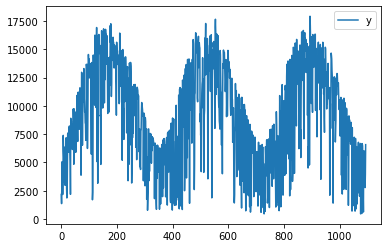

In [30]:
prophet_frame_new.plot()

In [31]:
# First fit the model by instantiating a new Prophet object
m = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=True)
m.fit(prophet_frame_new)

In [34]:
# Predictions are then made on a dataframe with a column ds containing the dates
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
1820,2021-12-26
1821,2021-12-27
1822,2021-12-28
1823,2021-12-29
1824,2021-12-30


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1820,2021-12-26,4258.305210,611.816831,8086.904693
1821,2021-12-27,4246.158344,627.850421,7998.359104
1822,2021-12-28,3811.827319,287.404746,7390.865830
1823,2021-12-29,4471.598930,896.024089,8419.064702
1824,2021-12-30,4794.335927,1102.859193,8912.166964


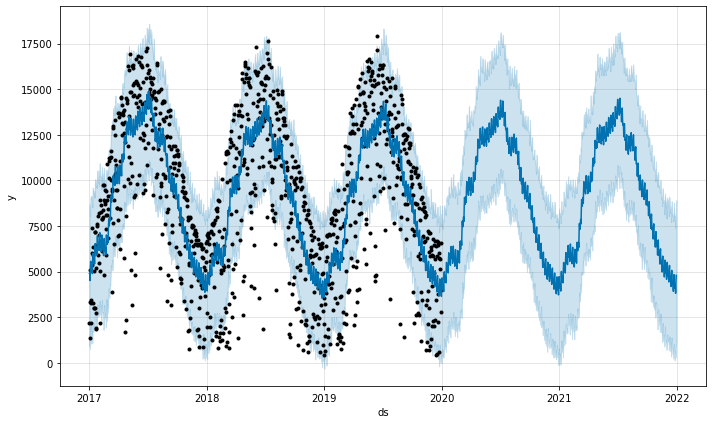

In [36]:
# Python
fig1 = m.plot(forecast)

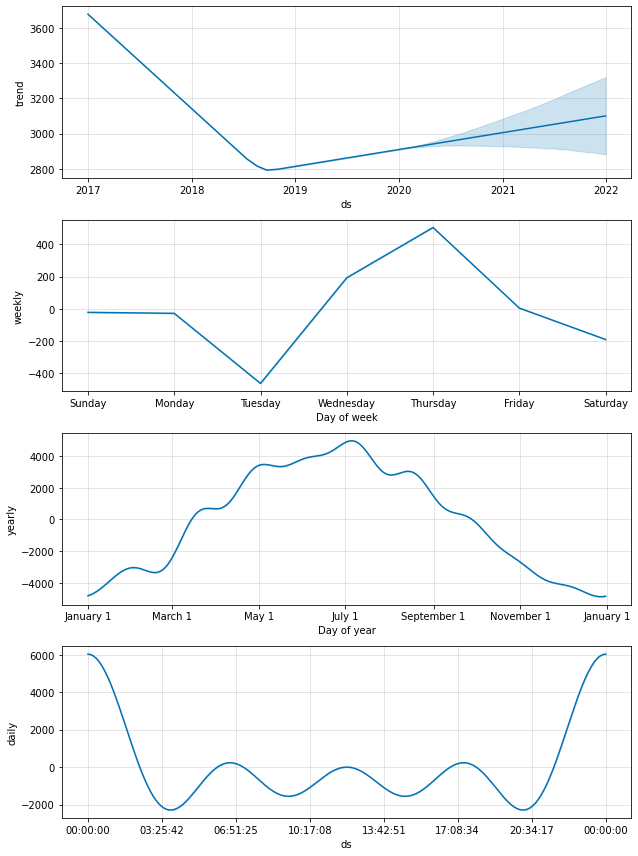

In [37]:
# Python
fig2 = m.plot_components(forecast)


In [38]:
# Python
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)